In [2]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mutual_info_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import MDS

import matplotlib.pyplot as plt

from keras.datasets import mnist

import sys
import os
sys.path.append(os.path.abspath('..'))
from utils.pcode import isProperSuperset, findDifferentElements, flatten, findLargestGaps, grouping, simpleGrouping
from utils.load import inflectionpoint, gen_corr_matrix

In [3]:
def generate_labeled_dataset(dimensions, num_samples, noise_ratio):
    # The total number of noise points
    num_noise = int(num_samples * noise_ratio)
    
    # The number of samples in each cluster
    num_cluster_samples = (num_samples - num_noise) // 2
    
    # Generate random centers for the two clusters
    center_1 = np.random.rand(dimensions)
    center_2 = np.random.rand(dimensions)
    
    # Generate the clusters around the random centers
    cluster_1 = center_1 + 10 * np.random.randn(num_cluster_samples, dimensions)
    cluster_2 = center_2 + 3 * np.random.randn(num_cluster_samples, dimensions)
    
    # Generate noise
    noise = np.vstack(((center_1 + 1 * np.random.randn(num_noise // 2, dimensions)),(center_2 + 1 * np.random.randn(num_noise - num_noise // 2, dimensions))))
    
    # Create labels for the clusters and noise
    labels_cluster_1 = np.zeros(num_cluster_samples)
    labels_cluster_2 = np.ones(num_cluster_samples)
    labels_noise = 2 * np.ones(num_noise)
    
    # Combine the clusters and noise
    data = np.vstack((cluster_1, cluster_2, noise))
    labels = np.concatenate((labels_cluster_1, labels_cluster_2, labels_noise))
    
    # Shuffle the dataset to mix noise and clusters
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    shuffled_data = data[indices]
    shuffled_labels = labels[indices]
    
    # Return the dataset as (vector, label)
    dataset = list(zip(shuffled_data, shuffled_labels))
    
    return dataset


dimensions = 32  # Dimension of the feature vector
num_samples = 100  # Total number of samples
noise_ratio = 0.1  # Ratio of noise

# Generate the dataset with labels
labeled_dataset = generate_labeled_dataset(dimensions, num_samples, noise_ratio)

# Let's check the first few entries to confirm its structure
X, y = np.array([x[0] for x in labeled_dataset]), np.array([x[1] for x in labeled_dataset])
# Check for any infinite values
print("Infinite values in X:", np.any(np.isinf(X)))
# Check for any values that are too large
print("Max value in X:", np.max(X))
print("Min value in X:", np.min(X))

X[:5], y[:5]




Infinite values in X: False
Max value in X: 36.74210649916418
Min value in X: -33.08652960012222


(array([[  8.77299004,   2.7359787 ,  -2.13586086,  -1.76264582,
          -0.19509059,  -0.36850415,  -0.22674939,  -0.85522729,
           1.70651172,   0.26666572,   2.06750365,   0.64956732,
           1.49829347,  -2.00339626,  -1.02062388,  -1.95424006,
           4.03295231,  -1.08495975,   2.89558262,   1.98160822,
           1.89529754,   0.71971596,   1.50032878,  -4.69986449,
          -0.16162009,   0.32656805,   1.3989187 ,   0.15386617,
           1.81497785,  -2.78279893,   5.06097047,   3.39397209],
        [ -3.16156356,  19.06679412, -12.38695181,  -2.99901536,
          18.10757194,  -1.0086536 , -11.11880311,  -2.44737975,
           2.15398513,  -1.27436864,   2.83915495,  13.27176276,
          -1.86925716,   3.30700842,   9.16526719,  -2.27981698,
           5.00597104,  19.76624145,  12.58961025,   0.57620973,
           1.93232683,   2.49406329,  20.18949133,  -2.98579148,
          -0.40876131,  -2.81808074,  -0.6022953 ,  -1.22842502,
         -17.20241546,  

In [3]:
# n_samples = 1000  # 数据集中的样本数
# n_features = 20   # 每个样本的特征数
# n_classes = 3     # 分类的类别数
# n_clusters_per_class = 1 # 每个类别的簇数

# # 生成数据集
# X, y = make_classification(n_samples=n_samples, n_features=n_features, n_classes=n_classes, 
#                            n_clusters_per_class=n_clusters_per_class, random_state=42)

# # # 展示一些生成的数据
# X[:5], y[:5]

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


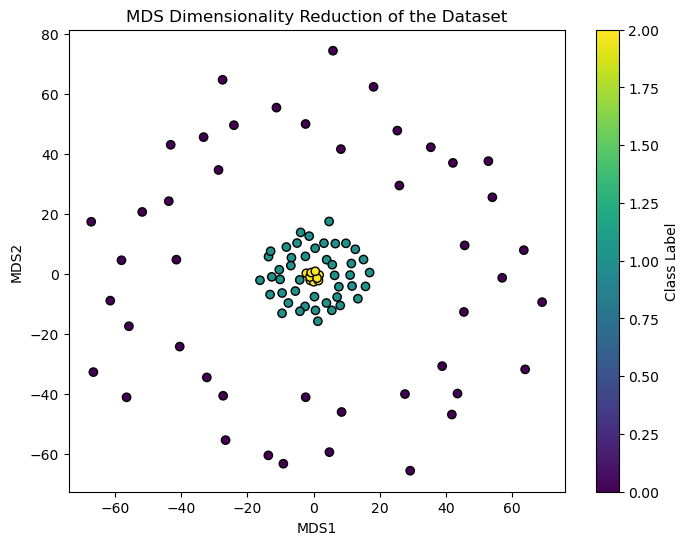

In [4]:
%matplotlib inline
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# 应用 MDS 降维
mds = MDS(n_components=2, random_state=0)
X_mds = mds.fit_transform(X)

# 绘制 MDS 结果
plt.figure(figsize=(8, 6))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title("MDS Dimensionality Reduction of the Dataset")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.colorbar(label='Class Label')
plt.show()



In [5]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# # 将图像数据转换为一维数组
# x_train_reshaped = x_train.reshape((x_train.shape[0], -1))
# x_test_reshaped = x_test.reshape((x_test.shape[0], -1))

# # 使用PCA进行数据降维以加快聚类过程
# pca = PCA(n_components=50)  # 选择50个主成分
# x_train_pca = pca.fit_transform(x_train_reshaped)
# x_test_pca = pca.transform(x_test_reshaped)

# # 使用前1000个样本进行聚类，以加快速度
# x_sample = x_train_pca[:1000]


In [6]:
def mean_distance(data, n):
    data = data.copy()
    distance_sum = 0

    for i in range(n):
        distance_sum += np.linalg.norm(data[i] - data[i+1])
    
    return distance_sum / n if n > 0 else 0

def show_inflectionpoint(data):
    # 假设 X 是您的数据集，它是一个形状为 (n_samples, n_features) 的 NumPy 数组
    # X = ... # 您的数据集

    # 选择k值，通常k = 4
    X = data.copy()
    k = 4

    # 使用sklearn的NearestNeighbors计算每个点的k-最近邻
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)

    # 对每个点的距离进行排序并绘制k-距离图
    sorted_distances = np.sort(distances, axis=0)[:, k-1]
    plt.plot(sorted_distances)
    plt.xlabel('Points sorted by distance to the k-th nearest neighbor')
    plt.ylabel(f'Distance to the k-th nearest neighbor (k={k})')
    plt.title('k-Distance Graph')
    plt.show()


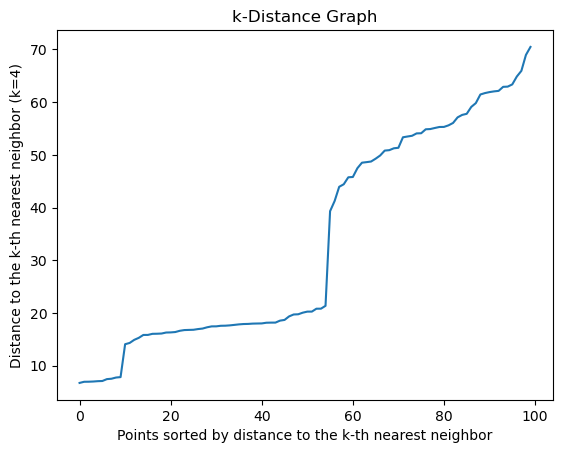

In [7]:
show_inflectionpoint(X)

In [8]:

# 定义聚类算法
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
dbscan = DBSCAN(eps=25, min_samples=5)
gmm = GaussianMixture(n_components=3, random_state=0)

In [9]:
labels_kmeans = kmeans.fit_predict(X)
labels_dbscan = dbscan.fit_predict(X)
labels_gmm = gmm.fit_predict(X)
labels_phg = simpleGrouping(gen_corr_matrix(X), 2)

print((labels_kmeans,labels_dbscan,labels_gmm,labels_phg))

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(array([0, 1, 2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       1, 0, 0, 1, 2, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0,
       1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 0, 2], dtype=int32), array([-1, -1, -1,  0, -1, -1,  0,  0,  0, -1, -1,  0, -1, -1,  0, -1,  0,
       -1,  0, -1,  0, -1, -1,  0,  0, -1, -1,  0, -1,  0,  0, -1, -1,  0,
        0,  0, -1, -1,  0, -1,  0, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1, -1,  0,  0, -1,  0,  0,  0, -1, -1, -1,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0, -1,  0, -1, -1,
       -1,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0, -1, -1, -1, -1]), array([1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1

In [10]:
silhouette_kmeans = silhouette_score(X, labels_kmeans)
silhouette_dbscan = silhouette_score(X, labels_dbscan)
silhouette_gmm = silhouette_score(X, labels_gmm)
silhouette_phg = silhouette_score(X, labels_phg)

davies_bouldin_kmeans = davies_bouldin_score(X, labels_kmeans)
davies_bouldin_dbscan = davies_bouldin_score(X, labels_dbscan)
davies_bouldin_gmm = davies_bouldin_score(X, labels_gmm)
davies_bouldin_phg = davies_bouldin_score(X, labels_phg)

calinski_harabasz_kmeans = calinski_harabasz_score(X, labels_kmeans)
calinski_harabasz_dbscan = calinski_harabasz_score(X, labels_dbscan)
calinski_harabasz_gmm = calinski_harabasz_score(X, labels_gmm)
calinski_harabasz_phg = calinski_harabasz_score(X, labels_phg)

# 由于Mutual Information需要真实标签，我们使用测试集的一部分
labels_true = y[:1000]
mutual_info_kmeans = mutual_info_score(labels_true, labels_kmeans)
mutual_info_dbscan = mutual_info_score(labels_true, labels_dbscan)
mutual_info_gmm = mutual_info_score(labels_true, labels_gmm)
mutual_info_phg = mutual_info_score(labels_true, labels_phg)

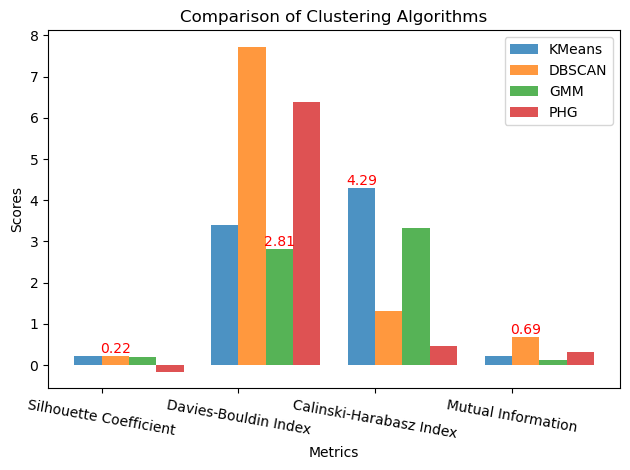

{'Silhouette Coefficient': {'KMeans': 0.2181950970411678, 'DBSCAN': 0.2249802603588726, 'GMM': 0.20733692059054254, 'PHG': -0.16092050681087172}, 'Davies-Bouldin Index': {'KMeans': 3.4083592423495173, 'DBSCAN': 7.72831881952955, 'GMM': 2.805540018327788, 'PHG': 6.382368818585365}, 'Calinski-Harabasz Index': {'KMeans': 4.286317858818508, 'DBSCAN': 1.3047162273663957, 'GMM': 3.3243840452166364, 'PHG': 0.47300372893821757}, 'Mutual Information': {'KMeans': 0.23090290257141022, 'DBSCAN': 0.6881388137135889, 'GMM': 0.12671469670138394, 'PHG': 0.32285773594755174}}


In [11]:
%matplotlib inline
# 定义评价指标和算法的数据
result = {
    "Silhouette Coefficient": {
        "KMeans": silhouette_kmeans,
        "DBSCAN": silhouette_dbscan,
        "GMM": silhouette_gmm,
        "PHG": silhouette_phg
    },
    "Davies-Bouldin Index": {
        "KMeans": davies_bouldin_kmeans,
        "DBSCAN": davies_bouldin_dbscan,
        "GMM": davies_bouldin_gmm,
        "PHG": davies_bouldin_phg
    },
    "Calinski-Harabasz Index": {
        "KMeans": calinski_harabasz_kmeans,
        "DBSCAN": calinski_harabasz_dbscan,
        "GMM": calinski_harabasz_gmm,
        "PHG": calinski_harabasz_phg
    },
    "Mutual Information": {
        "KMeans": mutual_info_kmeans,
        "DBSCAN": mutual_info_dbscan,
        "GMM": mutual_info_gmm,
        "PHG": mutual_info_phg
    }
}

# 转换数据格式以便绘图
metrics = list(result.keys())
algorithms = list(result[metrics[0]].keys())
scores = {algo: [result[metric][algo] for metric in metrics] for algo in algorithms}

# 计算每个指标的最佳得分
max_scores = {
    metric: max(result[metric].values()) if metric != 'Davies-Bouldin Index' else min(result[metric].values())
    for metric in metrics
}

# 绘制条形图
fig, ax = plt.subplots()
plt.xticks(rotation=-10)
bar_width = 0.2
opacity = 0.8
index = np.arange(len(metrics))

for i, algo in enumerate(algorithms):
    bars = ax.bar(index + i * bar_width, scores[algo], bar_width, alpha=opacity, label=algo)
    # 为最佳得分添加红色标注
    for bar, score, metric in zip(bars, scores[algo], metrics):
        if score == max_scores[metric]:
            # bar.set_color('red')
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(), '%.2f' % score, ha='center', va='bottom', color='red')

# 添加标签、标题和图例
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Clustering Algorithms')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()


# 展示图表
plt.tight_layout()
plt.show()

print(result)